In [1]:
import os # a library that gives us access to various command line tools to support pathing

import cartopy.crs as ccrs # a library that gives us access to cartopy's mapping capability
import cartopy.feature as cfeature # a library that extends cartopy to include features such as land masks

import matplotlib # the basic python plotting library
from matplotlib import gridspec # a library that gives us better control over plot spacing
import matplotlib.pyplot as plt # the basic Python plotting library figure tools

import xarray as xr # a library to extend array management and add labelling
import numpy as np # Python's array manipulation library 

import pandas as pd
import seaborn as sns
import warnings # a library to manage warnings
warnings.filterwarnings('ignore')

import ocean_support_functions_4F as osf

In [2]:
os.getcwd()

'C:\\Users\\ASUS\\Music\\datas\\Olci_ocean_color'

In [3]:
run_reduce_image = True
grid_factor = 3

# subset image: cut a relevant section out of an image. subset_extents [lon1,lon2,lat1,lat2] describes the section.
run_subset_image = True

# subset_extents = [87.55, 92.12,  21.0564, 22.1530]
subset_extents = [87.55, 92.12,  20.12, 23.0530]
# image plotting settings: e.g. fontsize (fsz)
fsz = 10
plt.rc('font', size=fsz)
dpi = 200

# get our land mask from NaturalEarth
land_poly = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='k', facecolor=cfeature.COLORS['land'],zorder =3)


# spectral_box_extents = [[91.4045,91.4983,22.1974, 22.2601],[89.87, 89.99,21.36, 21.41], [89.87, 89.99, 21.029,21.1001 ]]  #good match for 2021-April-09

spectral_box_extents = [[91.47,91.59,22.16, 22.21],[89.87, 89.99,21.36, 21.41], [89.87, 89.99, 20.66,20.71]]

spectral_plot_cols = ['darkred','cyan', 'yellow']

# Data Path

In [10]:
DATA_PATHS = [os.path.join('E:\Support_data\OLCI-2022\April_2022',
             'S3A_OL_2_WFR____20220320T035743_20220320T040043_20220321T162344_0179_083_161_2520_MAR_O_NT_003.SEN3')]

DATA_PATHS

['E:\\Support_data\\OLCI-2022\\April_2022\\S3A_OL_2_WFR____20220320T035743_20220320T040043_20220321T162344_0179_083_161_2520_MAR_O_NT_003.SEN3']

In [31]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'geo_coordinates.nc'))
rlat = ds1.latitude.data
rlon = ds1.longitude.data
ds1.close()

ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'chl_oc4me.nc'))
CHL_OC4ME = ds1.CHL_OC4ME.data
ds1.close()

ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'wqsf.nc'))
# get all the flag names
flag_names = ds1.WQSF.flag_meanings.split(' ')
# get all the flag bit values
flag_vals = ds1.WQSF.flag_masks
# get the flag field itself
FLAGS = ds1.WQSF.data
ds1.close()

# OC4ME standard flags
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED',
                 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ADJAC',
                 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6', 'RWNEG_O7', 'RWNEG_O8']
flag_mask_oc4 = osf.flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask_oc4 = flag_mask_oc4.astype(float)
flag_mask_oc4[flag_mask_oc4 == 0.0] = np.nan

In [32]:
ds1.attrs

{'absolute_orbit_number': 31704,
 'ac_subsampling_factor': 64,
 'al_subsampling_factor': 1,
 'comment': ' ',
 'contact': 'ops@eumetsat.int',
 'creation_time': '2022-03-21T16:23:44Z',
 'history': '  2022-03-21T16:23:44Z: PUGCoreProcessor /data/ipf-s3/workdir213/627694610/JobOrder.627694610.xml',
 'institution': 'MAR',
 'netCDF_version': '4.2 of Jul  5 2012 17:07:43 $',
 'product_name': 'S3A_OL_2_WFR____20220320T035743_20220320T040043_20220321T162344_0179_083_161_2520_MAR_O_NT_003.SEN3',
 'references': 'S3IPF PDS 004.3 - i2r3 - Product Data Format Specification - OLCI Level 2 Marine, S3IPF PDS 002 - i1r7 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i2r2 - Detailed Processing Model - OLCI Level 2',
 'resolution': '[ 270 294 ]',
 'source': 'IPF-OL-2 07.01',
 'start_time': '2022-03-20T03:57:42.560700Z',
 'stop_time': '2022-03-20T04:00:42.525737Z',
 'title': 'OLCI Level 2 WATER Product, Classification, Quality and Science Flags Data Set',
 'processing_baseline': 

In [33]:
ds1.attrs['start_time']

'2022-03-20T03:57:42.560700Z'

In [34]:
ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'chl_nn.nc'))       
CHL_NN = ds1.CHL_NN.data
ds1.close()

ds1 = xr.open_dataset(os.path.join(DATA_PATHS[0],'tsm_nn.nc'))       
TSM_NN = ds1.TSM_NN.data
ds1.close()

# NN standard flags
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED',
                 'SUSPECT', 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE','OCNN_FAIL']
flag_mask_nn = osf.flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask_nn = flag_mask_nn.astype(float)
flag_mask_nn[flag_mask_nn == 0.0] = np.nan

# apply flag masks

CHL_OC4ME[np.isfinite(flag_mask_oc4)] = np.nan
CHL_NN[np.isfinite(flag_mask_nn)] = np.nan
TSM_NN[np.isfinite(flag_mask_nn)] = np.nan

In [35]:
TSM_mean = [] ; TSM_std = []
CHL_NN_mean = [] ; CHL_NN_std = []
CHL_OC4ME_mean = [] ; CHL_OC4ME_std = []
for spectral_box_extent in spectral_box_extents:
    print('Processing box...')
    I1, I2, J1, J2 = osf.get_coords(rlon, spectral_box_extent[0], spectral_box_extent[1],\
                                    rlat, spectral_box_extent[2], spectral_box_extent[3], False)
    print(I1, I2, J1, J2)
    TSM_mean.append(np.nanmean(10**TSM_NN[I1:I2,J1:J2]))
    TSM_std.append(np.nanstd(10**TSM_NN[I1:I2,J1:J2]))
    CHL_NN_mean.append(np.nanmean(10**CHL_NN[I1:I2,J1:J2]))
    CHL_NN_std.append(np.nanstd(10**CHL_NN[I1:I2,J1:J2]))
    CHL_OC4ME_mean.append(np.nanmean(10**CHL_OC4ME[I1:I2,J1:J2]))
    CHL_OC4ME_std.append(np.nanstd(10**CHL_OC4ME[I1:I2,J1:J2]))

Processing box...
3092 3120 2813 2853
Processing box...
3503 3530 2281 2322
Processing box...
3761 3788 2339 2380


In [36]:
np.nanmean(10**TSM_NN[I1:I2,J1:J2])

0.14896221

In [37]:
# x = pd.DataFrame(TSM_NN)
# x.duplicated().sum()
# x =x.iloc[1630: 1673,3891 :3918]
# len(x)

In [38]:

# 10**x

In [39]:
# x.duplicated().sum()

In [40]:

# y = x.iloc[:4,:3]
# y

In [21]:
# np.mean(y.iloc[:4,:3]) #so it was coloumn based mean , and axis = 0 as given by default

In [22]:


# if run_subset_image:
#     i1, i2, j1, j2 = osf.subset_image(rlat, rlon, subset_extents)
#     lon = rlon[i1:i2,j1:j2]
#     lat = rlat[i1:i2,j1:j2]
#     CHL_OC4ME = CHL_OC4ME[i1:i2,j1:j2]
#     CHL_NN = CHL_NN[i1:i2,j1:j2]
#     TSM_NN = TSM_NN[i1:i2,j1:j2]

# if run_reduce_image:
#     CHL_OC4ME = osf.reduce_image(CHL_OC4ME, grid_factor=grid_factor)
#     CHL_NN = osf.reduce_image(CHL_NN, grid_factor=grid_factor)
#     TSM_NN = osf.reduce_image(TSM_NN, grid_factor=grid_factor)
#     lon = osf.reduce_image(rlon, grid_factor=grid_factor)
#     lat = osf.reduce_image(rlat, grid_factor=grid_factor)

In [68]:
round(10**2.2)

158

Algorithm: OC4ME


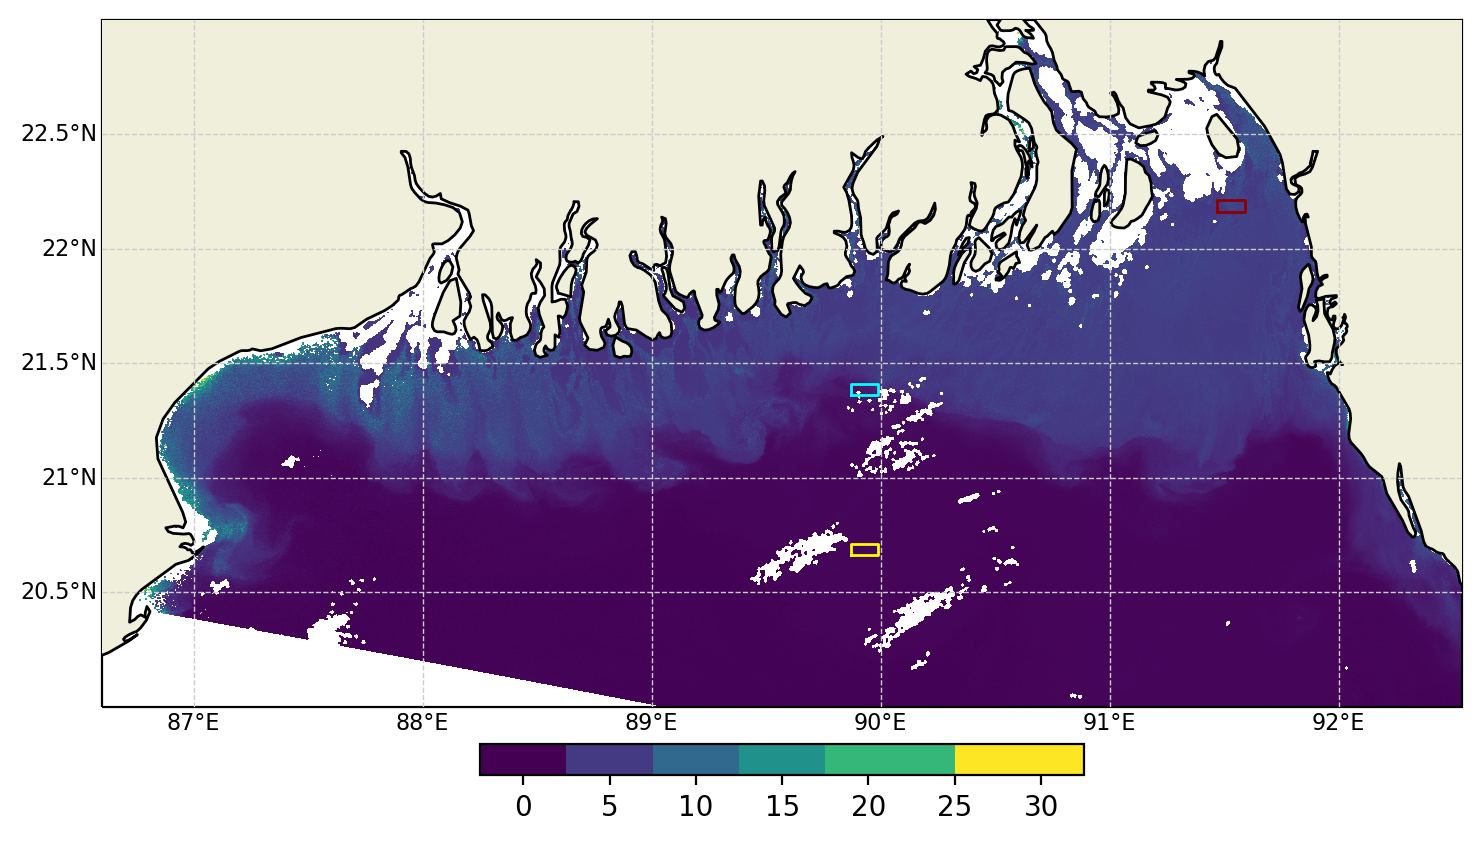

In [41]:
fig1 = plt.figure(figsize=(10, 5), dpi=200)
gs = gridspec.GridSpec(1, 1)

# make axes and plot
for ii in range(1):
    if ii ==1 : 
        var = CHL_NN
        print("Algorihm: NN")
    else:
        var = CHL_OC4ME
        print("Algorithm: OC4ME")
        
    m = plt.subplot(gs[0,ii], projection=ccrs.PlateCarree())
    m.set_extent([86.6, 92.54,  20, 23])
    p1 = osf.plot_OLCI_scene(m, rlon, rlat, 10**var,vmin=0, vmax=30)
    
    cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.04, pad=0.05 , shrink = .6,values = [0,5,10,15,20,30])

#     cbar.ax.set_xticklabels(['0','5','10','20','>30'], fontsize=6)

    
    
    
#     # embellish with spectral boxes

    m.add_feature(land_poly)
    osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)
    gl = m.gridlines(draw_labels=True, zorder=30, color='.8', linestyle='--',linewidth=0.5)
    gl.top_labels   = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8, 'color': 'black'}
    gl.ylabel_style = {'size': 8, 'color': 'black'}

# add caption

# fig1.text(0.5, 0.0, r'Figure 3: Chlorophyll-a concentration derived using OC4ME (left)'+'\n'\
#           'and C2RCC (right).', ha='center', fontsize=fsz)
plt.show()

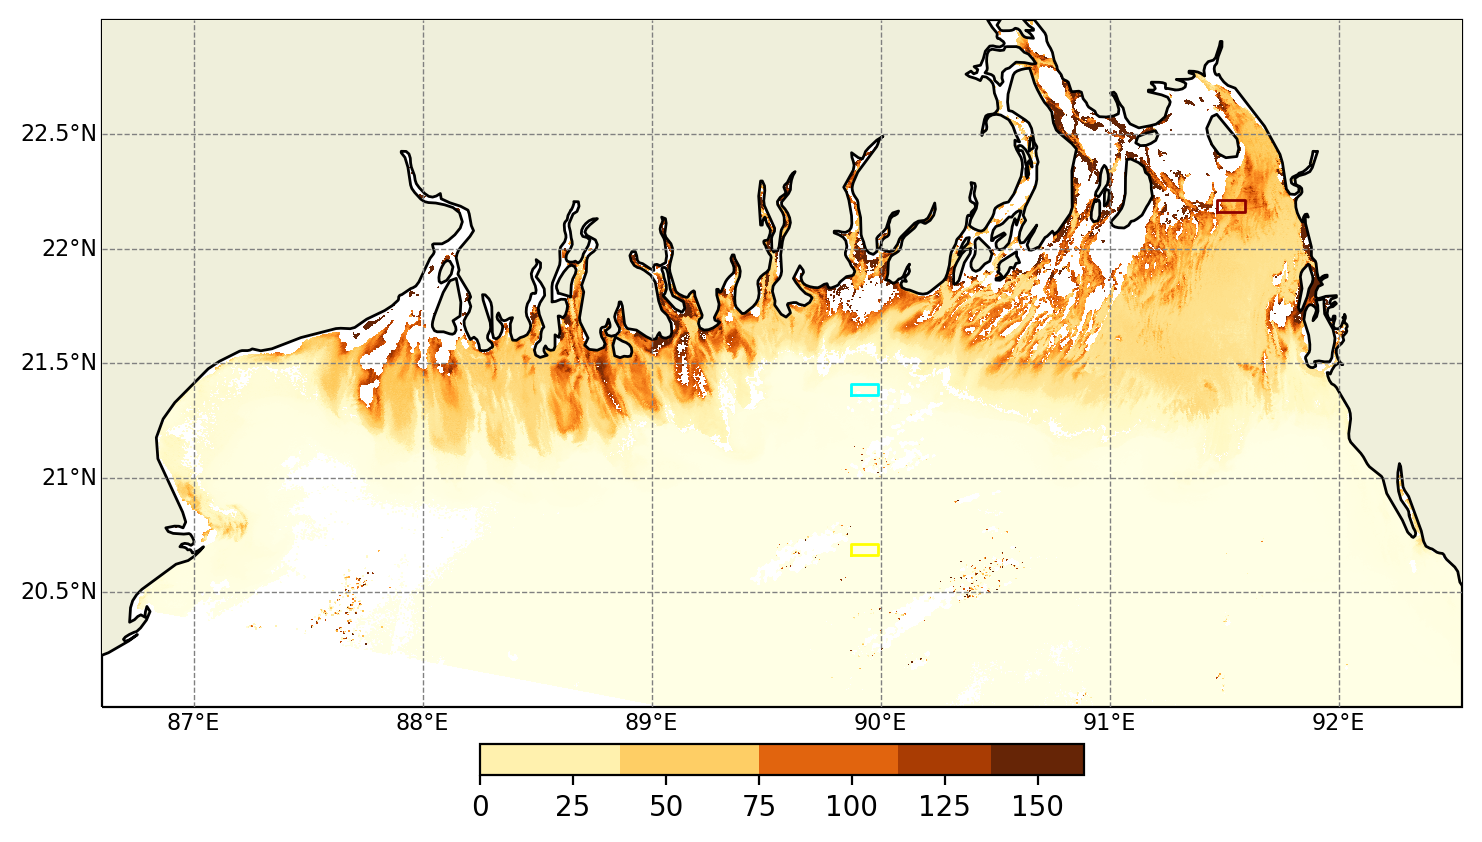

In [24]:
fig1 = plt.figure(figsize=(10,5), dpi=200)
gs = gridspec.GridSpec(1, 1)

# make an axis and plot
m = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
p1 = osf.plot_OLCI_scene(m, rlon[::1], rlat[::1], 10**TSM_NN[::1], cmap=plt.cm.YlOrBr,vmin=0, vmax=150)
cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.04, pad=0.05,shrink = .6,values = [25,50,100,125,150])

m.set_extent([86.6, 92.54,  20, 23])


# cbar.ax.set_xticklabels(10**np.asarray([-2,-1,0,1,2]).astype(float), fontsize=8)

m.coastlines(resolution='10m', color='black', linewidth=0.25)
m.add_feature(land_poly)
# embellish with spectral boxes
osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

gl = m.gridlines(draw_labels=True, zorder=30, color='0.5', linestyle='--',linewidth=0.5)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}

# make an axis and plot
# m = plt.subplot(gs[0,1], projection=ccrs.Mercator())
# anom = (10**(CHL_OC4ME) - 10**(CHL_NN))
# anom[anom < -10] = -10 ; anom[anom > 10] = 10
# p1 = osf.plot_OLCI_scene(m, rlon, rlat, anom, cmap=plt.cm.RdBu_r)
# m.set_extent([87.39, 92.54,  20, 23])
# cbar = plt.colorbar(p1, orientation="horizontal", fraction=0.05, pad=0.1, ticks=[-10,-5,0,5,10])
# cbar.ax.set_xticklabels([-10,-5,0,5,10], fontsize=fsz)
# m.coastlines(resolution='10m', color='black', linewidth=0.25)
# m.add_feature(land_poly)
# # embellish with spectral boxes
# osf.add_boxes(m, spectral_plot_cols, spectral_box_extents)

# add caption
# fig1.text(0.5, 0.0, r'Figure 4: TSM derived from C2RCC (left), different between'+'\n'\
#           'two chlorophyll-a products (right).', ha='center', fontsize=fsz)
plt.show()

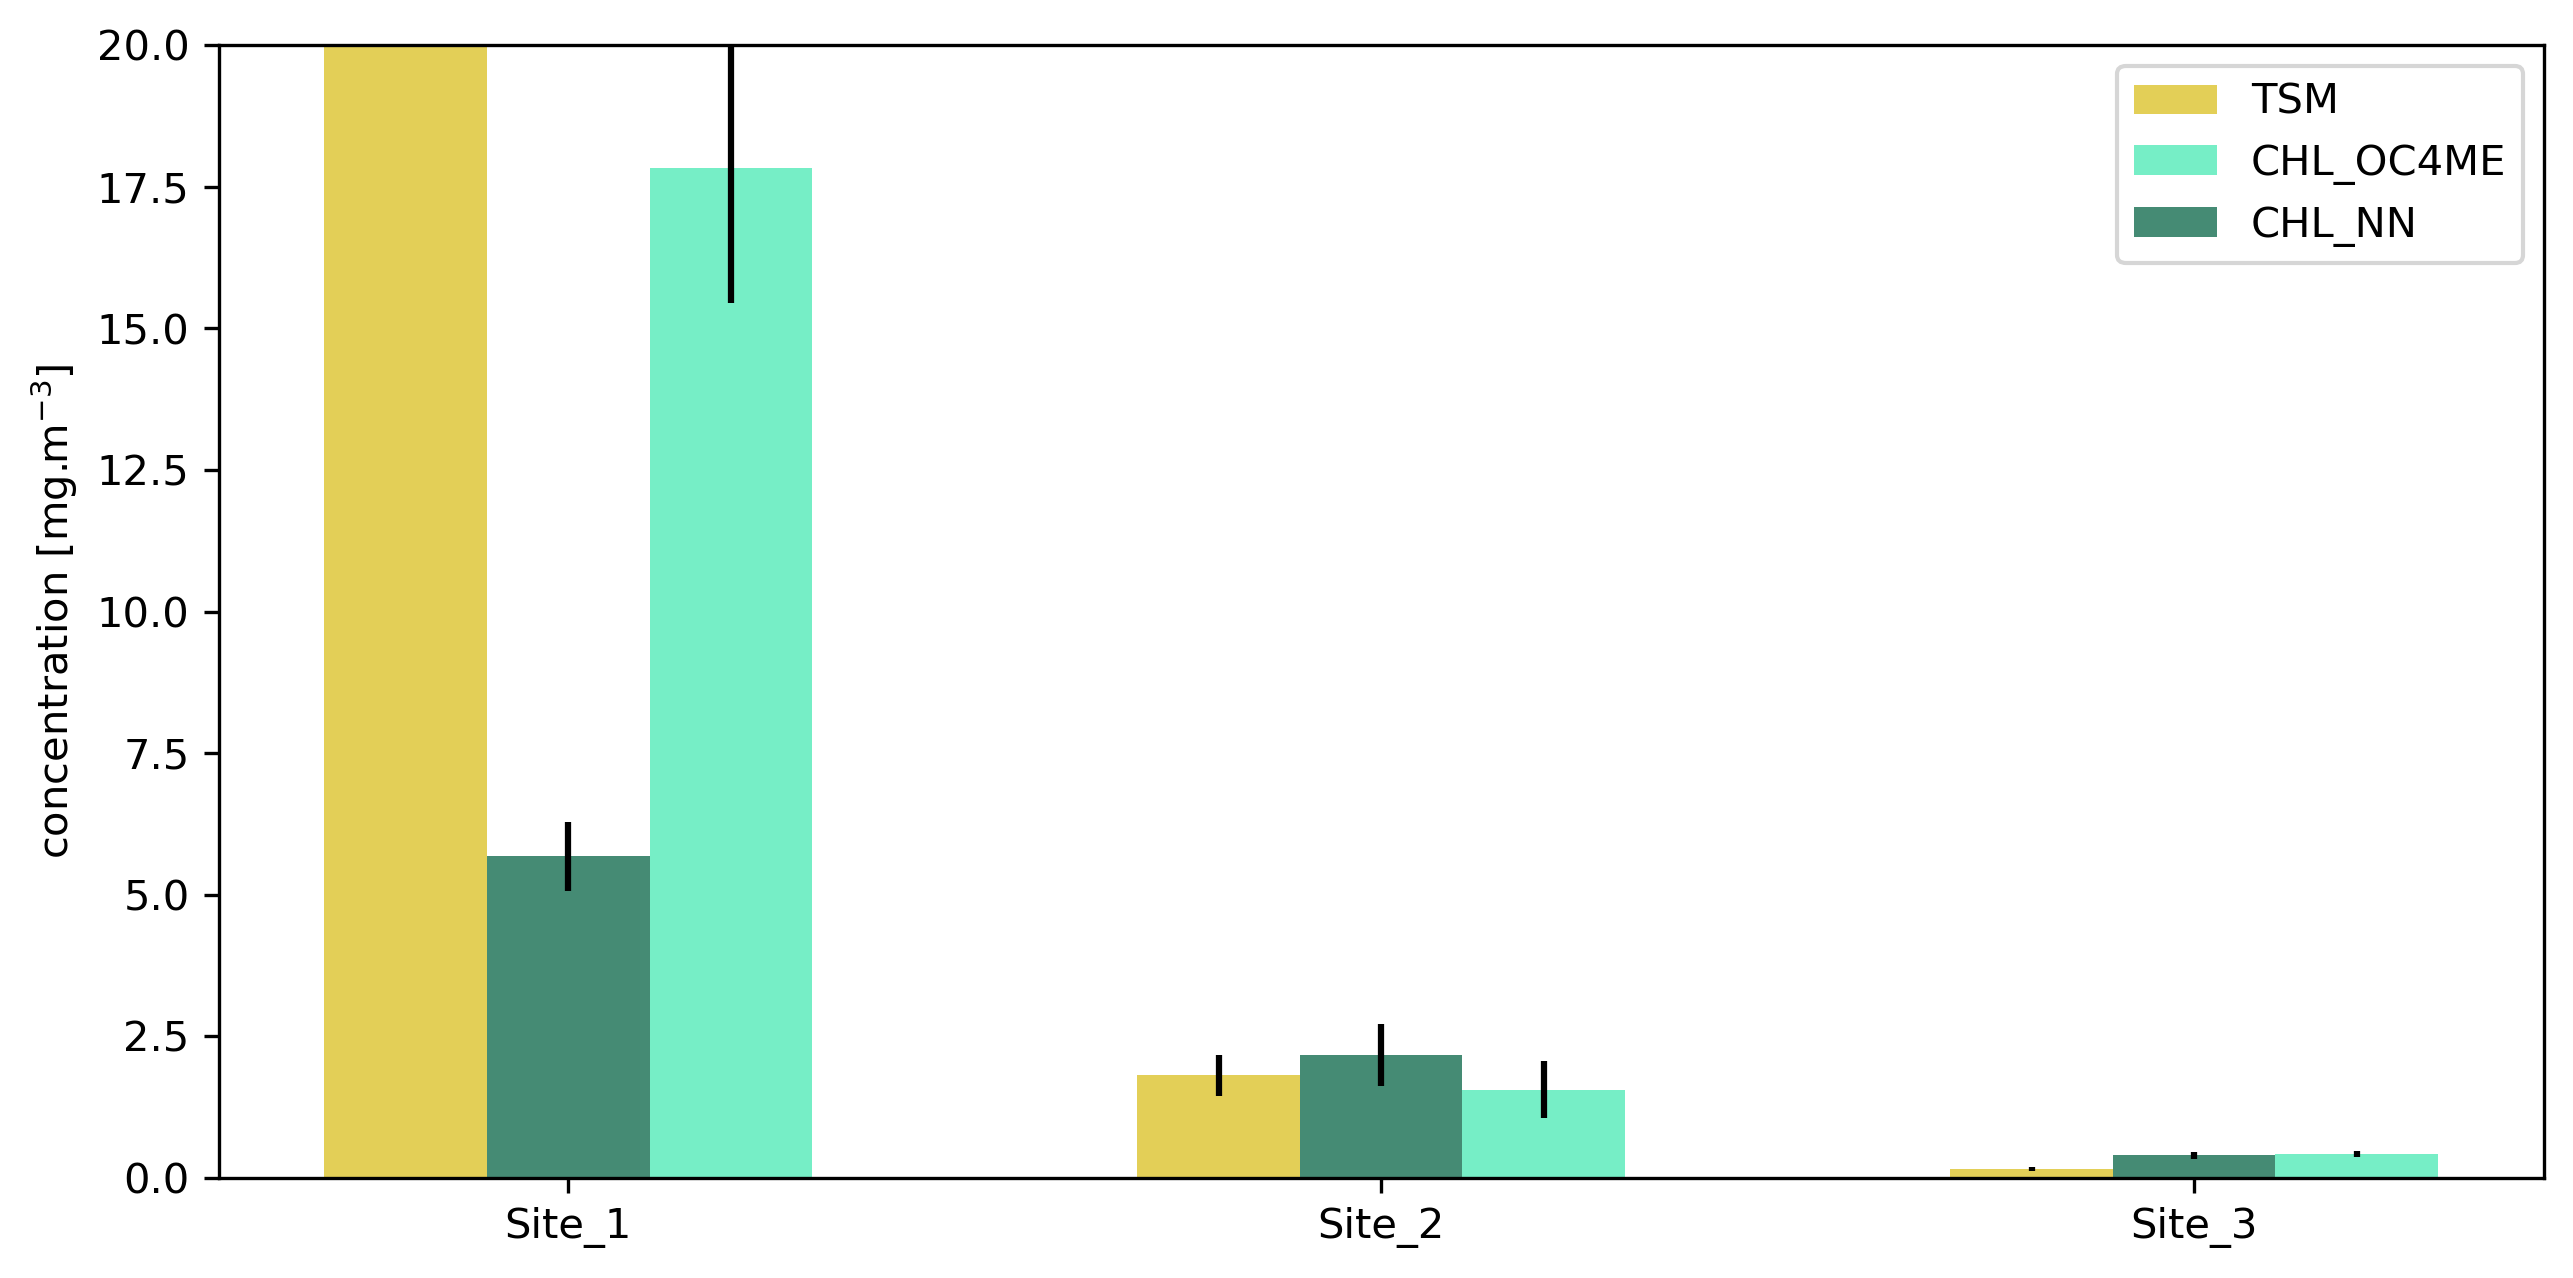

In [25]:

labels = ['Site_1','Site_2','Site_3']
fig1 = plt.figure(figsize=(10, 5), dpi=300)
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])


tsm = plt.bar([0,1,2], TSM_mean, yerr=TSM_std, align='center', width=0.2, color='#E3CF57')
CHL_NN = plt.bar([0.4,1.4,2.4], CHL_NN_mean, yerr=CHL_NN_std, align='center', width=0.2, color='#76EEC6')
CHL_OC4ME = plt.bar([0.2,1.2,2.2], CHL_OC4ME_mean, yerr=CHL_OC4ME_std, align='center', width=0.2, color='#458B74')


ax.legend([tsm, CHL_NN,CHL_OC4ME],  ['TSM','CHL_OC4ME','CHL_NN'])
ax.set_ylabel('concentration [mg.m$^{-3}$]')
ax.set_xticks([0.2,1.2,2.2])
ax.set_xticklabels(labels)
plt.ylim([0,20])

# for ii in range(len(spectral_box_extents)):
#     ax.get_xticklabels()[ii].set_color(spectral_plot_cols[ii])
    
# add caption
# fig1.text(0.5, 0.0, r'Figure 5: A comparison of TSM (yellow), standard chlorophyll (dark green)'+'\n'\
#           'and NN chlorophyll (light green) across our test boxes.', ha='center', fontsize=fsz)
plt.show()

In [26]:
np.nanmax(TSM_std)

13.841182

[Text(0.2, 0, 'Site_1'), Text(1.2, 0, 'Site_2'), Text(2.2, 0, 'Site_3')]

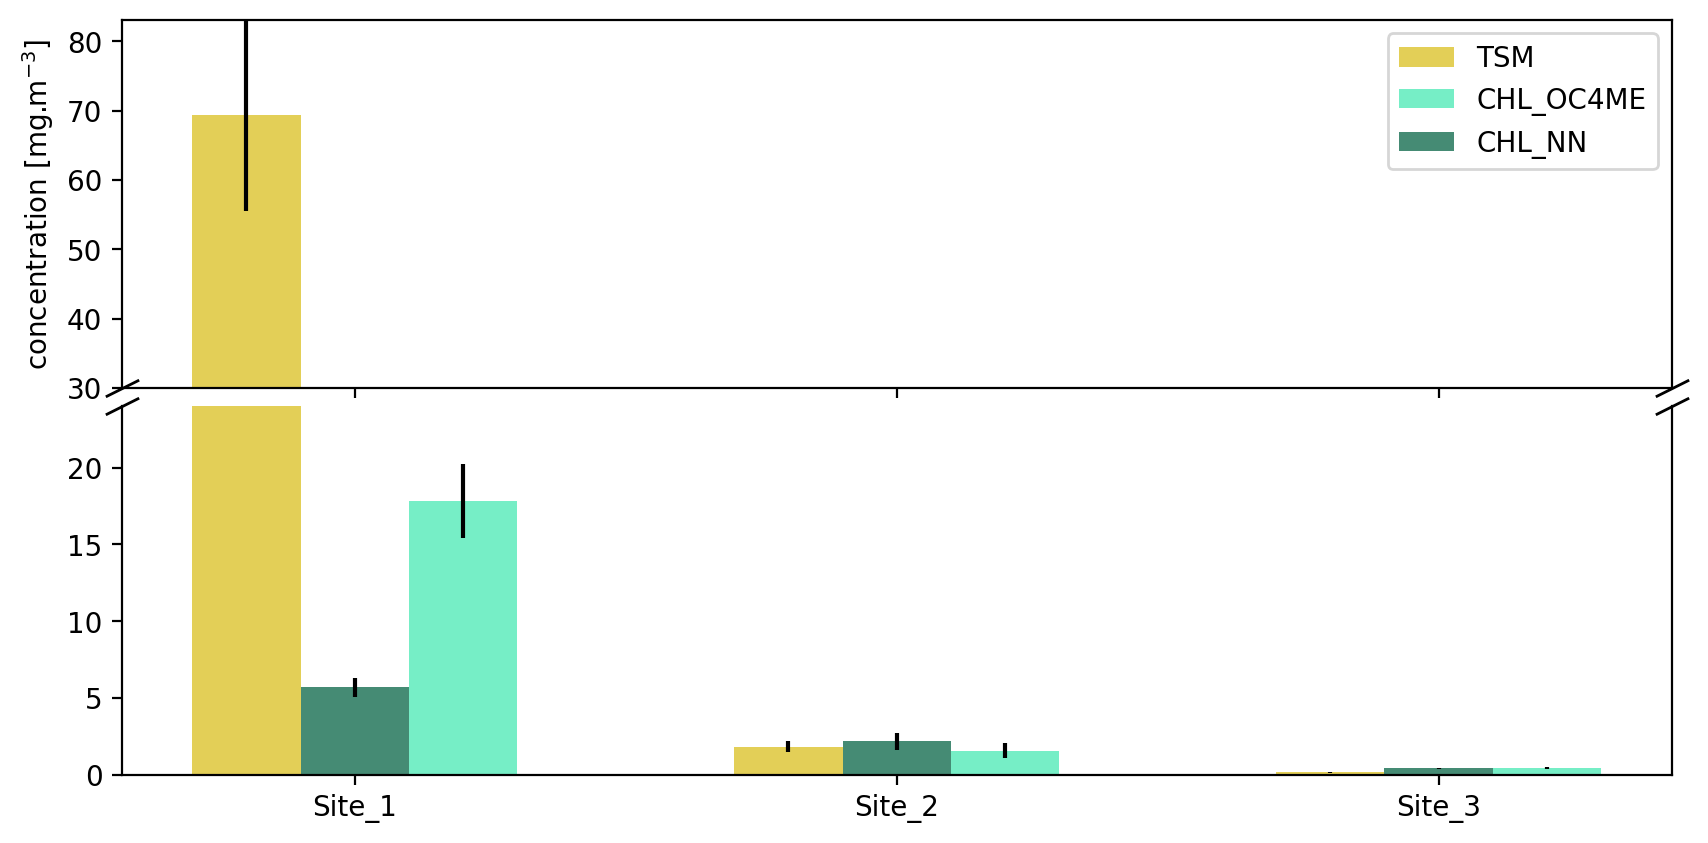

In [27]:
labels = ['Site_1','Site_2','Site_3']
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,5), dpi =200)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

ax1.set_ylim(30,np.nanmax(TSM_mean)+ np.nanmax(TSM_std))  # outliers only
ax2.set_ylim(0, 24)  # most of the data

# plot the same data on both axes
tsm = ax1.bar([0,1,2], TSM_mean, yerr=TSM_std, align='center', width=0.2, color='#E3CF57')
ax2.bar([0,1,2], TSM_mean, yerr=TSM_std, align='center', width=0.2, color='#E3CF57')

# ///////////////////////////...................../////////////////////////////////////
CHL_NN= plt.bar([0.4,1.4,2.4], CHL_NN_mean, yerr=CHL_NN_std, align='center', width=0.2, color='#76EEC6')
CHL_OC4ME = plt.bar([0.2,1.2,2.2], CHL_OC4ME_mean, yerr=CHL_OC4ME_std, align='center', width=0.2, color='#458B74')


# ax2.plot(pts)
# ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()

# ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.legend([tsm, CHL_NN,CHL_OC4ME],  ['TSM','CHL_OC4ME','CHL_NN'])
ax1.set_ylabel('concentration [mg.m$^{-3}$]')
ax2.set_xticks([0.2,1.2,2.2])
ax2.set_xticklabels(labels)



In [42]:
October_01_2021 =pd.DataFrame({"chl_NN_mean":CHL_NN_mean, "chl_oc4me_mean":CHL_OC4ME_mean,"tsm_mean":TSM_mean,
                             "chl_nn_std":CHL_NN_std, "chl_oc4me_std":CHL_OC4ME_std, "tsm_std":TSM_std, 
                              "time":"April-2022", "exact_time":ds1.attrs['start_time']} )

# for i in range(0,3):
#     january_4_2021['box'][i] = i+1  # if doesn't work then try at first without [i], then add [i]


October_01_2021['Site'] = [1,2,3]
October_01_2021


,chl_NN_mean,chl_oc4me_mean,tsm_mean,chl_nn_std,chl_oc4me_std,tsm_std,time,exact_time,Site
0,17.834826,5.680972,69.294067,2.387812,0.610780,13.841182,April-2022,2022-03-20T03:57:42.560700Z,1
1,1.556499,2.163720,1.810367,0.500270,0.546631,0.364153,April-2022,2022-03-20T03:57:42.560700Z,2
2,0.418045,0.398904,0.148962,0.055276,0.059919,0.034335,April-2022,2022-03-20T03:57:42.560700Z,3


In [43]:
# October_01_2021.to_csv('E:\\Support_data\\March_20_2022.csv')

In [1]:
import pandas as pd 
df = pd.read_csv('E:\\Support_data\\Ocober_29_2020.csv')
df =df.drop("Unnamed: 0", axis =1)
df

,chl_NN_mean,chl_oc4me_mean,tsm_mean,chl_nn_std,chl_oc4me_std,tsm_std,time,exact_time,Site
0,17.359959,6.915688,100.000000,2.745003,1.555233,0.000000,October-2020,2020-10-29T04:03:04.285311Z,1
1,10.437381,28.396654,22.665434,0.953065,3.435440,5.024009,October-2020,2020-10-29T04:03:04.285311Z,2
2,0.820853,0.330823,0.935900,0.309582,0.055578,0.270507,October-2020,2020-10-29T04:03:04.285311Z,3


In [2]:
# df.iloc[0,5]=1
# df

In [3]:
df2 = pd.read_csv('E:\\Support_data\\October_01_2021.csv')
df2 =df2.drop("Unnamed: 0", axis =1)
df2

,chl_NN_mean,chl_oc4me_mean,tsm_mean,chl_nn_std,chl_oc4me_std,tsm_std,time,exact_time,Site
0,17.769796,5.276302,243.439800,3.243743,0.361767,17.665823,October-2021,2021-10-01T04:05:10.582803Z,1
1,4.454446,9.573164,8.119727,0.387379,4.691566,2.571549,October-2021,2021-10-01T04:05:10.582803Z,2
2,1.373691,0.747457,1.685253,0.199762,0.111026,0.272334,October-2021,2021-10-01T04:05:10.582803Z,3


In [4]:
df =pd.concat([df,df2],ignore_index=True)
df

,chl_NN_mean,chl_oc4me_mean,tsm_mean,chl_nn_std,chl_oc4me_std,tsm_std,time,exact_time,Site
0,17.359959,6.915688,100.000000,2.745003,1.555233,0.000000,October-2020,2020-10-29T04:03:04.285311Z,1
1,10.437381,28.396654,22.665434,0.953065,3.435440,5.024009,October-2020,2020-10-29T04:03:04.285311Z,2
2,0.820853,0.330823,0.935900,0.309582,0.055578,0.270507,October-2020,2020-10-29T04:03:04.285311Z,3
3,17.769796,5.276302,243.439800,3.243743,0.361767,17.665823,October-2021,2021-10-01T04:05:10.582803Z,1
4,4.454446,9.573164,8.119727,0.387379,4.691566,2.571549,October-2021,2021-10-01T04:05:10.582803Z,2
5,1.373691,0.747457,1.685253,0.199762,0.111026,0.272334,October-2021,2021-10-01T04:05:10.582803Z,3


In [122]:

df.groupby(["time", "Site"]).mean()



chl_NN_mean  chl_oc4me_mean    tsm_mean  chl_nn_std  \
time         Site                                                        
October-2020 1       17.359959        6.915688  100.000000    2.745003   
             2       10.437381       28.396654   22.665434    0.953065   
             3        0.820853        0.330823    0.935900    0.309582   
October-2021 1       17.769796        5.276302  243.439800    3.243743   
             2        4.454446        9.573164    8.119727    0.387379   
             3        1.373691        0.747457    1.685253    0.199762   

                   chl_oc4me_std    tsm_std  
time         Site                            
October-2020 1          1.555233   0.000000  
             2          3.435440   5.024009  
             3          0.055578   0.270507  
October-2021 1          0.361767  17.665823  
             2          4.691566   2.571549  
             3          0.111026   0.272334

Text(0.5, 0, 'Time and Locations')

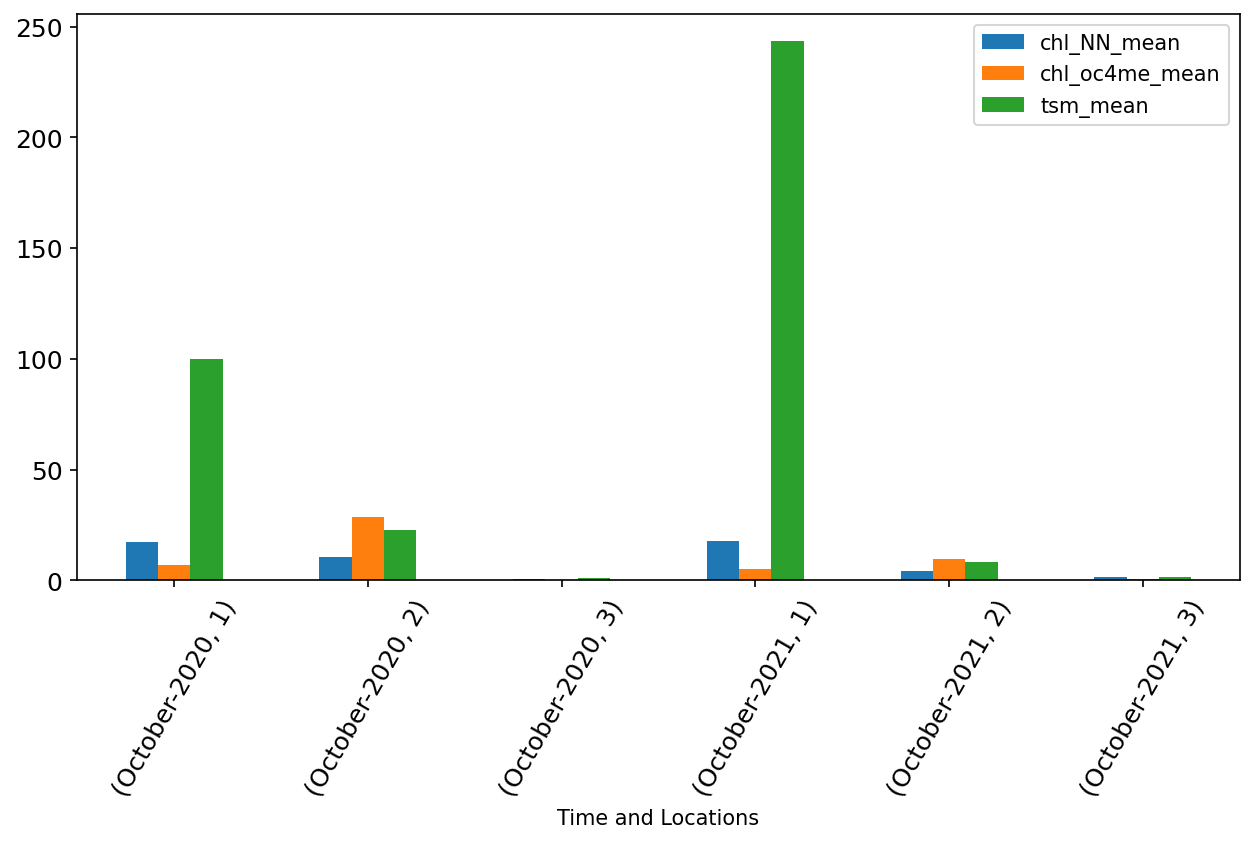

In [123]:
fig, ax = plt.subplots(figsize = (10,5),dpi =150)
df.groupby(["time", "Site"]).mean().plot(kind ='bar', ax =ax,y =["chl_NN_mean","chl_oc4me_mean","tsm_mean"],
                                          fontsize =12 )
plt.xticks(rotation=60)
# ax.set_xticklabels(["a","b","c",1,2,3])
ax.set_xlabel("Time and Locations")

In [124]:
df.chl_NN_mean.shape


(12,)

<AxesSubplot:xlabel='time', ylabel='chl_NN_mean'>

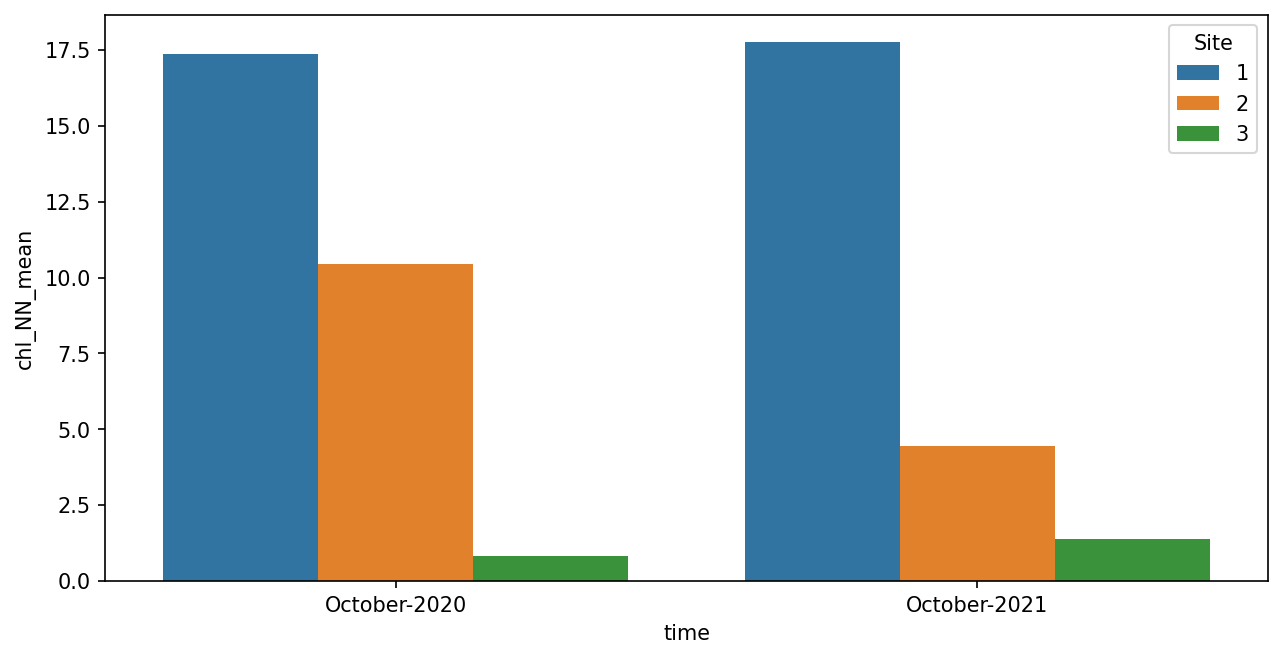

In [127]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,5),dpi =150)
sns.barplot(x = df.time, y =df.chl_NN_mean,hue = df.Site,ax =ax )

In [ ]:
fig1 = plt.figure(figsize=(10, 5), dpi=dpi)
df.groupby(df.box).mean().plot(kind ='bar', width =.8,)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
plt.figure(figsize = (10,7))
from shapely.geometry.polygon import LinearRing

    
# map_quest_aerial = cimgt.MapQuestOpenAerial()
ax = plt.axes(projection= ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([87.55, 92.12,  20.12, 23.0530], ccrs.PlateCarree())
# ax.add_image(map_quest_aerial)

lons = [91.65965155792365, 91.70909003448615,91.70909003448615, 91.65965155792365]
lats = [22.220892791686914, 22.220892791686914, 22.257437915416606, 22.257437915416606]
ring = LinearRing(list(zip(lons, lats)))
ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='yellow', edgecolor='red')

gl = ax.gridlines(draw_labels=True, zorder=30, color='0.5', linestyle='--',linewidth=0.5)
gl.top_labels   = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

plt.show()


In [ ]:
ring

In [ ]:
[,
[,]
[,]
[,]
[91.65965155792365,22.220892791686914]